In [1]:
# Add the root path of the pyqula library
import os ; import sys
try: sys.path.append(os.environ["PYQULAROOT"]) # add the library via environmental variable
except: 
    try: from pyqula import geometry # check if the library is present
    except: # pyqula not installed
        print("pyqula needs to be installed, installing it")
        import subprocess ; subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade","pyqula"])

# some default parameters in matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'coolwarm'


import numpy as np

# Advanced Quantum Materials, session 7: Magnetism, magnons, quantum magnetism and spinons
In this session we will address several systems featuring magnetism, and understand their origin

### Contents
- Symmetry breaking by magnetic interactions
- The strong coupling limit of a magnetic system
- Intermediate coupling regime and Stoner instability
- Non-collinear magnetism from competing interactions
- Non-collinear magnetism from spin-orbit coupling
- Non-collinear magnetism from magnetic frustration

### Learning outcomes
- Understand the impact of electronic repulsion in an electronic structure
- Rationalize the intermediate and strong coupling regimes of an interacting magnetic system
- Understand mechanisms leading to non-collinear magnetism

### How the exercises are organized
- (Remider): These are introductory exercises. You can skip them if you feel comfortable with basics of the topic
- (Exercise): Conventional exercise
- Quiz: short questions to answer, for Exercise or Reminder

### It is not necessary to complete all the exercises, you can just focus on those that sound most interesting for you.

## (Reminder) Bandstructure of a tight binding chain with two sites
We will start showing the magnetic instabilities of a 1D chain at half filling, with two sites per unit cell

([], [])

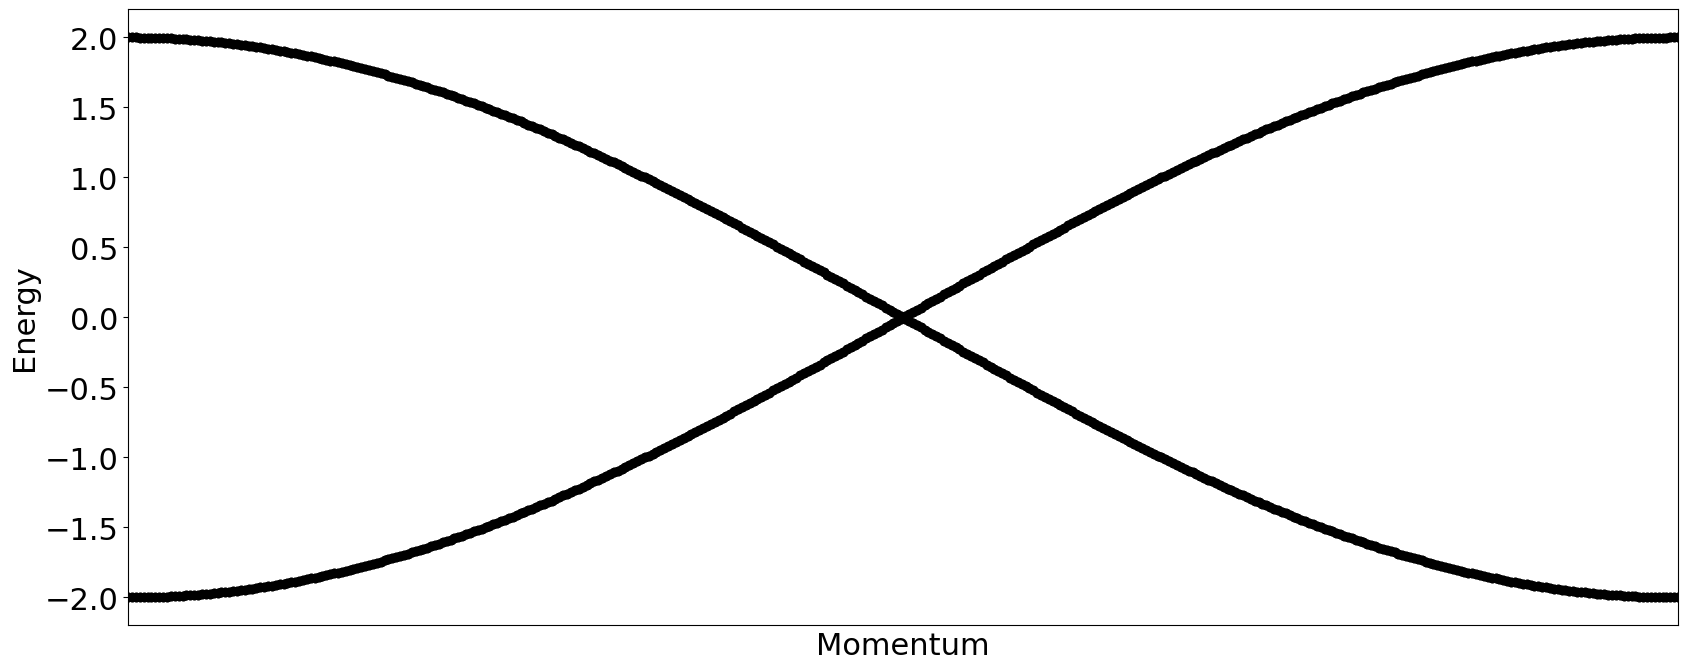

In [2]:
from pyqula import geometry
g = geometry.chain() # generate a chain
NS = 2 # size of the supercell
g = g.get_supercell(NS) # make a supercell
h = g.get_hamiltonian() # generate the Hamiltonian
(k,e) = h.get_bands() # compute band structure
plt.xlim([min(k),max(k)]) # adjust plot
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

### Quiz
- Discuss why there are two bands in this chain
- Change the size of the supercell, how many bands do you have and why?

## (Exercise) Magnetic order driven by interactions in a chain

(np.float64(-3.85),
 np.float64(3.85),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

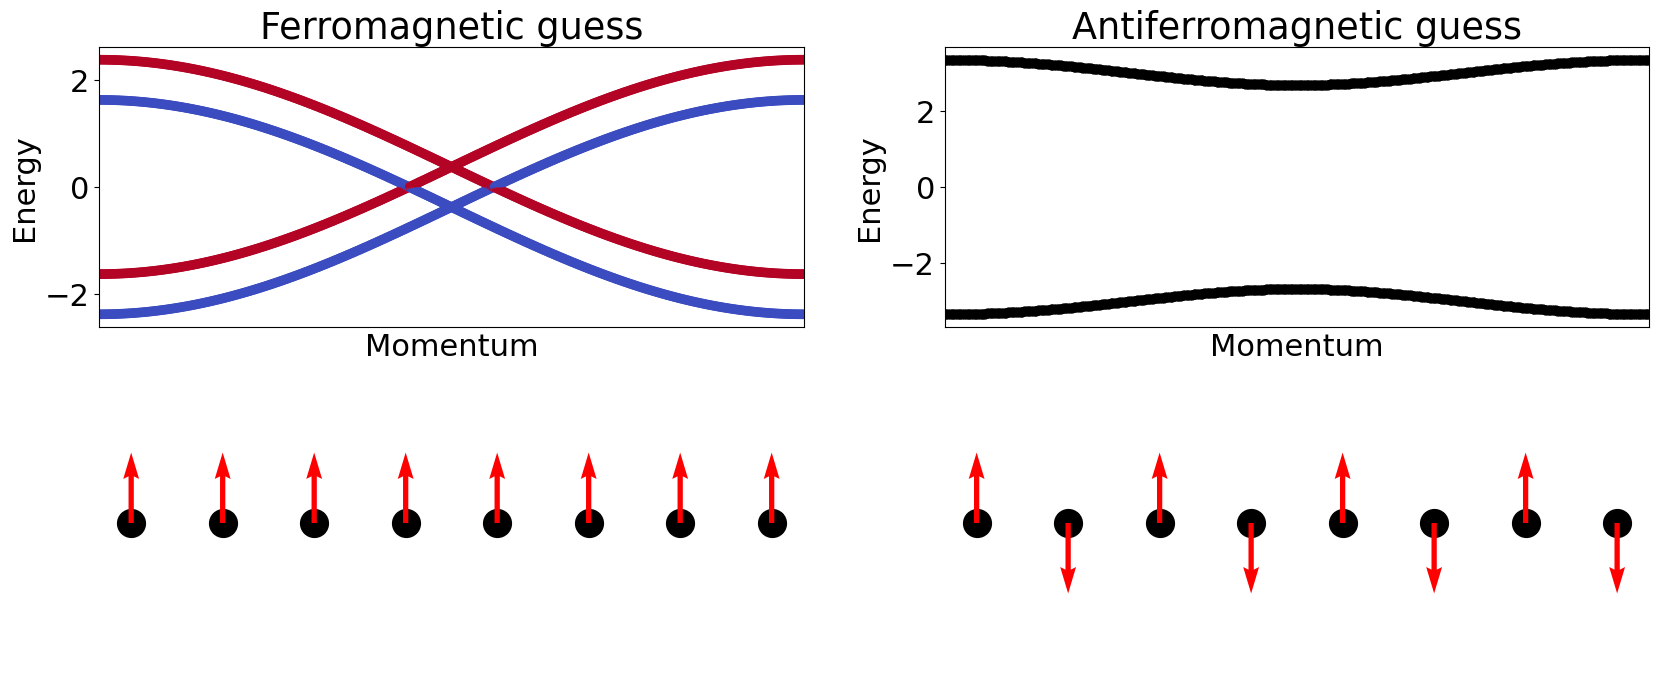

In [3]:
# let us now add interactions, and compute the electronic structure
from pyqula import geometry
g = geometry.bichain() # generate a chain with two sites per unit cell (with internal sublattice)
h = g.get_hamiltonian() # generate the Hamiltonian

U = 6.0 # value of the local interaction

# first with a ferromagnetic guess
plt.subplot(2,2,1)
plt.title("Ferromagnetic guess")
hfe = h.get_mean_field_hamiltonian(U=U,mf="ferro") # solve the interacting problem with a mean-field guess
(k,e,c) = hfe.get_bands(operator="sz") # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) 
plt.xlim([min(k),max(k)]) # plot

# plot magnetization
hs = hfe.get_supercell(4) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,3)
mz = hs.extract("mz") ; x = gs.r[:,0] ; y = gs.r[:,1] 
mz = mz/np.max(np.abs(mz)) # normalize
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,0.,mz,color="red",scale=10) ; plt.axis("off") # plot

# and with an antiferromagnetic guess
plt.subplot(2,2,2)
plt.title("Antiferromagnetic guess")
haf = h.get_mean_field_hamiltonian(U=U,mf="antiferro") # solve the interacting problem with a mean-field guess
(k,e) = haf.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) 
plt.xlim([min(k),max(k)]) # plot

# plot magnetization
hs = haf.get_supercell(4) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,4)
mz = hs.extract("mz") ; x = gs.r[:,0] ; y = gs.r[:,1] 
mz = mz/np.max(np.abs(mz)) # normalize
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,0.,mz,color="red",scale=10) ; plt.axis("off") # plot

### Quiz
- Discuss which solution you think it has the lowest energy, and why
- Compute the selfconsistent solution for stronger values of the interaction. Which change do you observe?

## (Reminder) The spectra of a dimer
Here we will review the electronic spectra of a tight binding dimer

Text(0.5, 0, 'State index')

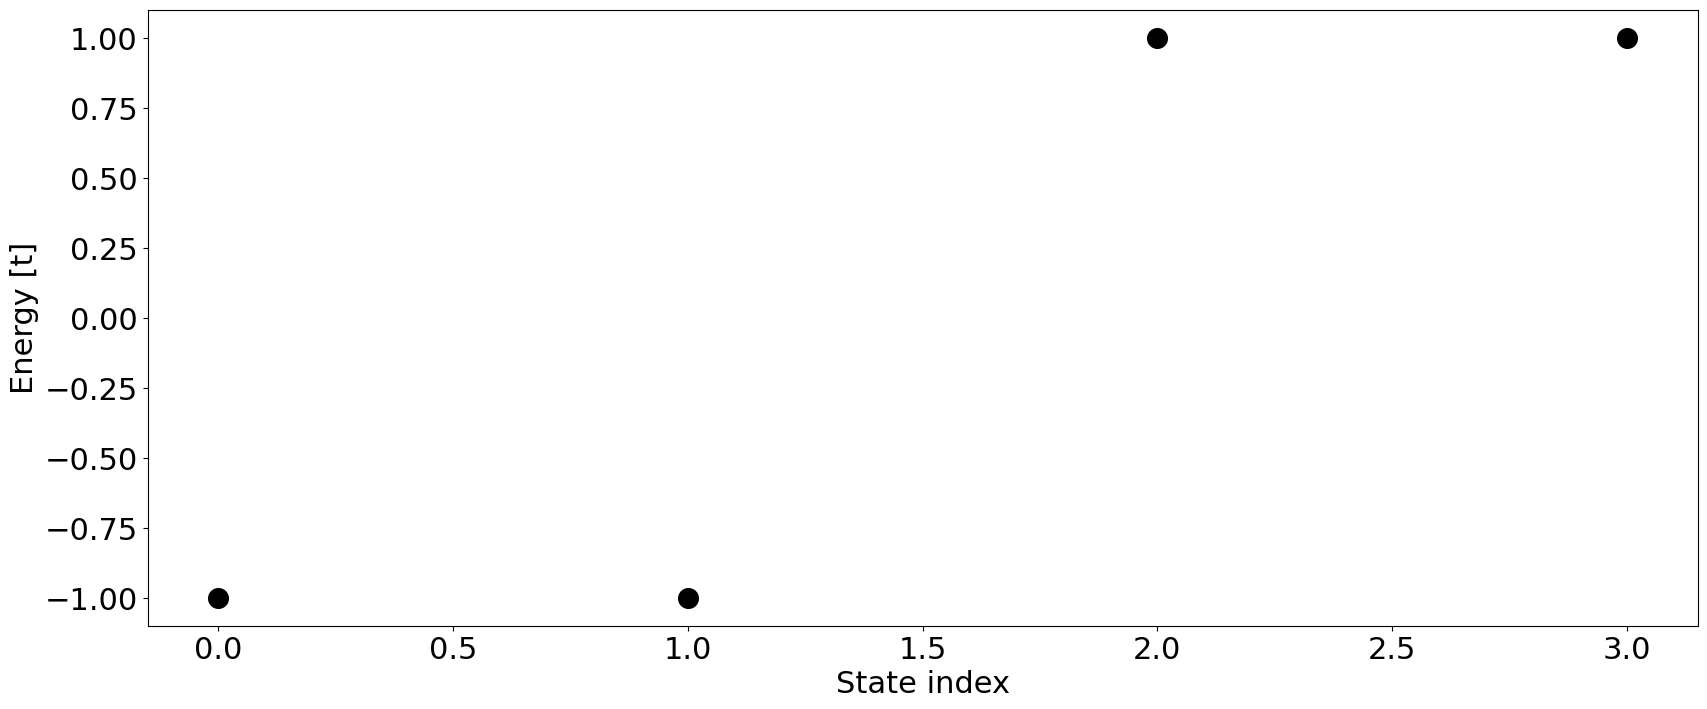

In [4]:
from pyqula import geometry
g = geometry.bichain() # generate a chain with two sites per unit cell (with internal sublattice)
g.dimensionality = 0 # just retain the two sites per unit cell


h = g.get_hamiltonian(has_spin=True) # generate Hamiltonian

(ks,es) = h.get_bands() # get bands
plt.scatter(range(len(es)),es,c="black",s=200) ; plt.ylabel("Energy [t]") ; plt.xlabel("State index")

### Quiz
- There two sites in the system, why do we have four eigenstates?
- Why are the state degenerate in energy?

## (Exercise) The interacting Hubbard dimer
Here we will see how the magnetization evolves in an interacting dimer chain

Text(0, 0.5, '$\\langle S_z \\rangle $')

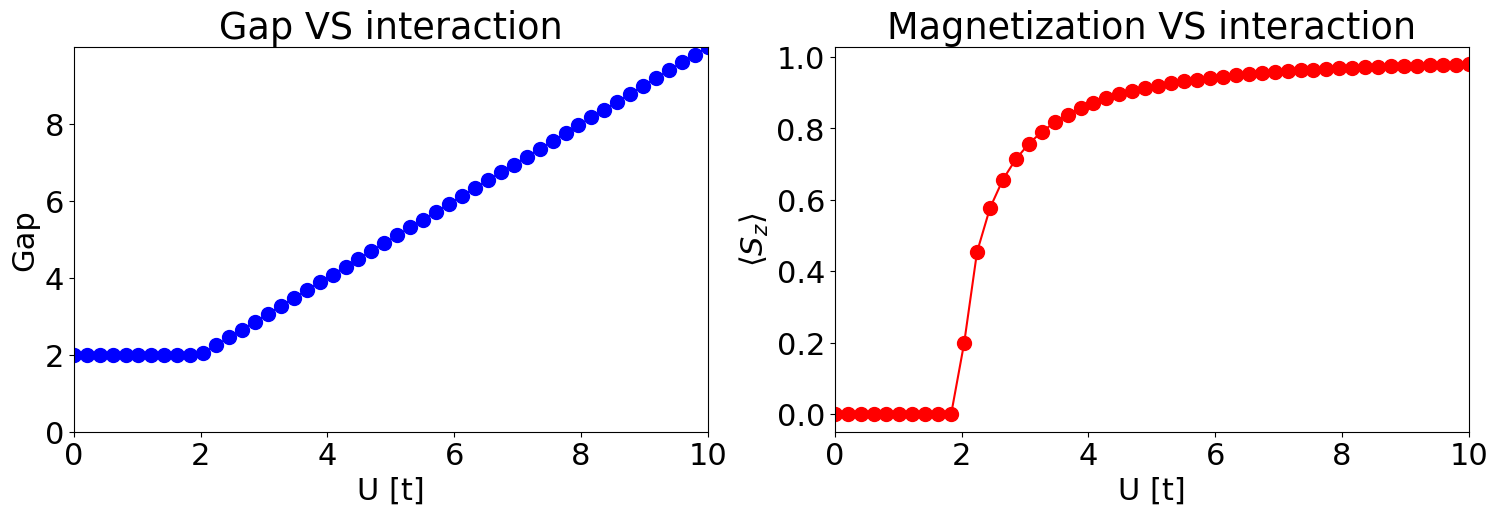

In [5]:
from pyqula import geometry
g = geometry.bichain() # generate a chain with two sites per unit cell (with internal sublattice)
L = 1 # size of the system
g = g.get_supercell(L) # make a supercell
g.dimensionality = 0 # just retain the two sites per unit cell
h0 = g.get_hamiltonian() # generate the Hamiltonian

Us = np.linspace(0.,10.,50) # number of interactions
mzs = [] # empty list for magnetizations
gaps = [] # gaps of the systems
for U in Us:
    h = h0.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9) # perform SCF
    mz = h.get_vev("mz")[1] # magnetization of the second site
    mzs.append(abs(mz)) # store magnetization in that size
    gaps.append(h.get_gap()) # compute gap of the system and store it


plt.figure(figsize=(18,5))

plt.subplot(1,2,1) # plot the magnetization VS interaction
plt.title("Gap VS interaction")
plt.plot(Us,gaps,marker="o",c="blue",markersize=10) ; plt.xlim([min(Us),max(Us)])
plt.xlabel("U [t]") ; plt.ylabel("Gap") ; plt.ylim([0,max(gaps)])

plt.subplot(1,2,2) # plot the magnetization VS interaction
plt.title("Magnetization VS interaction")
plt.plot(Us,mzs,marker="o",c="red",markersize=10) ; plt.xlim([min(Us),max(Us)])
plt.xlabel("U [t]") ; plt.ylabel("$\\langle S_z \\rangle $")

### Quiz
- Identify the non-interacting limit in the plot
- Identify the strongly interacting limit in the plot
- Why does the magnetization saturate at large interactions?
- Why is there a critical value to have magnetization?

## Gap opening in the Hubbard model
We will now see how the Hubbard interaction give rise to a gap opening in an interacting chain

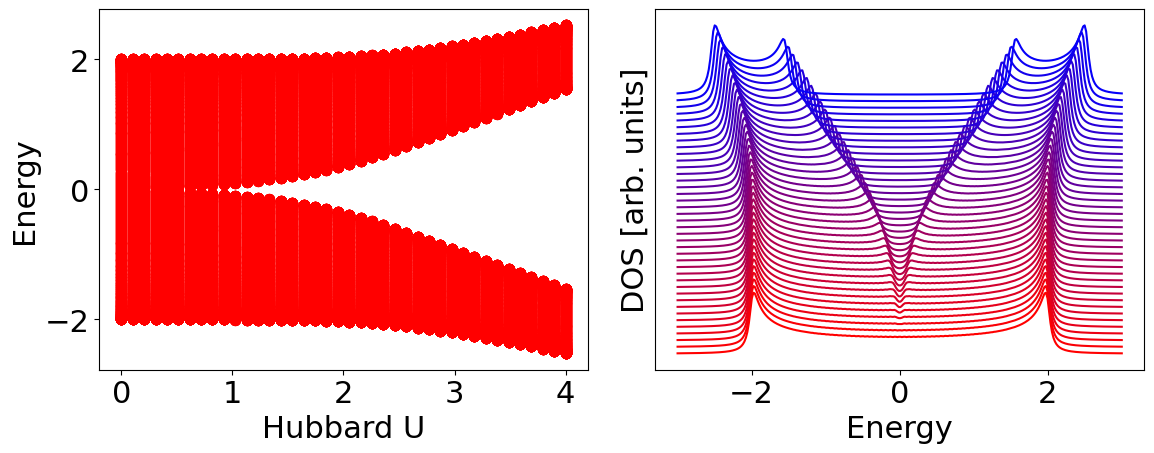

In [6]:
fig = plt.figure(figsize=(12,5))

Us = np.linspace(0.,4.0,40)

g = geometry.bichain() # generate a chain
h0 = g.get_hamiltonian() # generate the Hamiltonian
iU = 0 # counter
for U in Us:
    h = h0.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9) # perform SCF
#    h = h0.get_mean_field_hamiltonian(U=U,mf="ferro",mix=0.9) # perform SCF, with a ferromagnetic initialization
    (k,e) = h.get_bands() # compute band structure
    edos = np.linspace(-3,3.,300) # energies for the DOS
    (edos,ddos) = h.get_dos(energies=edos)
    plt.subplot(1,2,1)
    plt.scatter(e*0. + U,e,c="red",s=50)
    plt.subplot(1,2,2)
    c = iU/len(Us) # float for the color of the plot
    plt.plot(edos,ddos+iU/4.,c=(1-c,0,c))
    iU += 1
plt.subplot(1,2,1)
plt.xlabel("Hubbard U") ; plt.ylabel("Energy")

plt.subplot(1,2,2)
plt.xlabel("Energy") ; plt.ylabel("DOS [arb. units]") ; plt.yticks([])

plt.tight_layout()

### Quiz
- Use a ferromagnetic initialization, what happens and why?

## (Exercise) The strongly interacting limit
Let us now compare the energies of a ferromagnetic and antiferromagnetic state in the strong coupling limit

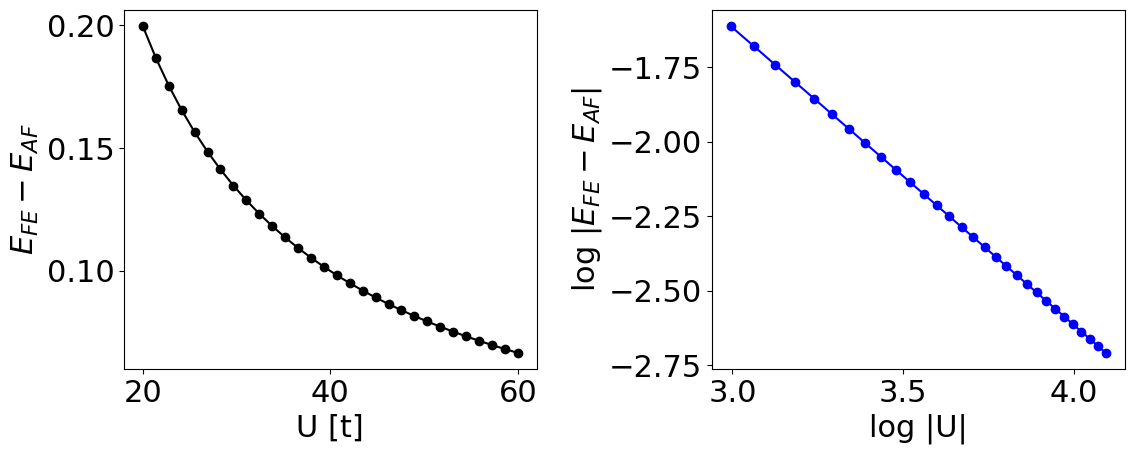

In [7]:
# let us now compute the energy difference as a function of U
from pyqula import geometry

fig = plt.figure(figsize=(12,5))
def get_energy_difference(U):
    g = geometry.bichain() # generate a chain with two sites per unit cell
    h = g.get_hamiltonian() # generate the Hamiltonian
    (hfe,efe) = h.get_mean_field_hamiltonian(U=U,return_total_energy=True,mf="ferro",mix=0.9) # FE
    (haf,eaf) = h.get_mean_field_hamiltonian(U=U,return_total_energy=True,mf="antiferro",mix=0.9) # AF
    return efe - eaf

Us = np.linspace(20.,60,30) # values of U considered

Et = [get_energy_difference(U) for U in Us] # energy differences

plt.subplot(1,2,1)
plt.plot(Us,Et,c="black",marker="o") # plot total energy VS value of U
plt.xlabel("U [t]") ; plt.ylabel("$E_{FE} - E_{AF}$")

plt.subplot(1,2,2)
plt.plot(np.log(np.abs(Us)),np.log(np.abs(Et)),c="blue",marker="o") # plot total energy VS value of U
plt.xlabel("log |U|") ; plt.ylabel("log |$E_{FE} - E_{AF}$|")

plt.tight_layout()

### Quiz
- Which state has the lowest energy?
- Discuss why the dependence of 1/U is observed in the energy differences between FE and AF configurations
- Compute this very same curve but going to lower values of U. Why does the 1/U behavior break down?

## (Exercise) Intermediate coupling regime and Stoner instability
Let us now show how there is a critical value of the electronic interaction to develop time-reversal symmetry breaking

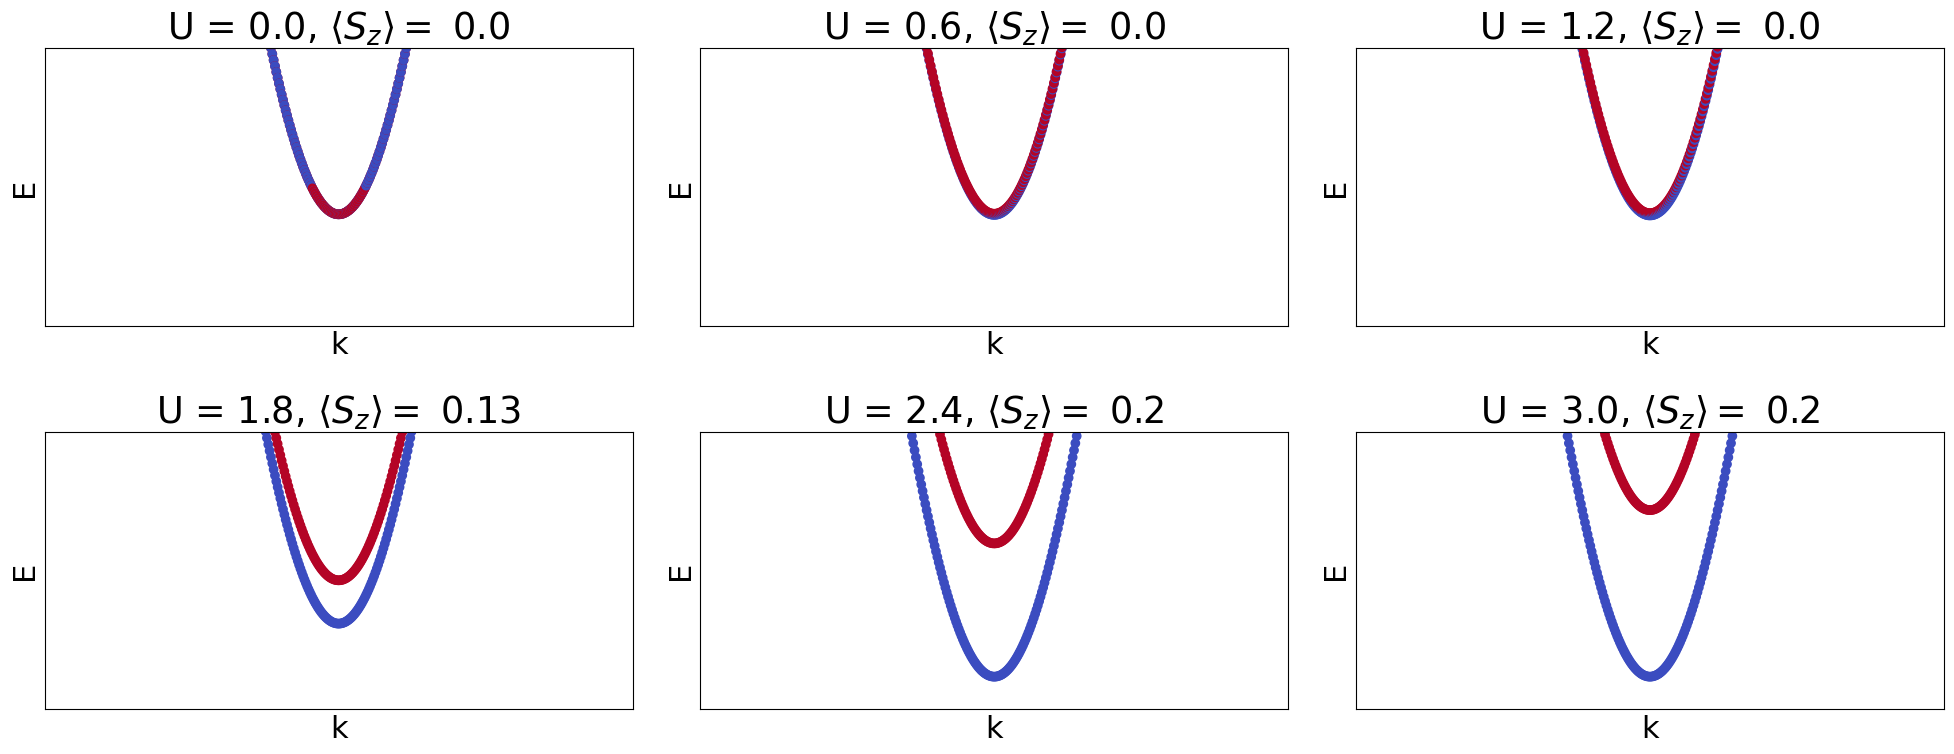

In [8]:
from pyqula import geometry
N = 6 # number of plots
Us = np.linspace(0.,3.0,N) # strengths of electronic interaction

ii = 1 # counter for the subplots
for U in Us:
    g = geometry.chain() # generate a chain
    h = g.get_hamiltonian() # generate the Hamiltonian
    h = h.get_mean_field_hamiltonian(U=U,filling=0.1,mf="ferro",mix=0.9,nk=300) # perform SCF
    plt.subplot(N//3,3,ii); ii += 1 
    (k,e,c) = h.get_bands(operator="sz") # compute band structure
    jz = np.mean(np.abs(h.get_vev("mz"))) # magnetization
    plt.title("U = "+str(np.round(U,2))+", $\\langle S_z \\rangle = $ "+str(np.round(jz,2))) # set the title
    plt.scatter(k,e,c=c) ; plt.yticks([]) ; plt.xticks([]) ; plt.ylim([-.5,.5]) ; plt.xlabel("k") ; plt.ylabel("E")
plt.tight_layout() # adjust the subplots

### Exercise
- Perform the calculation at a smaller filling (0.05 for example). Does the critical value increase or decrease?
- Perform the calculation at a bigger filling (0.2 for example). Does the critical value increase or decrease?
- Discuss why the critical value leading to magnetism changes

## (Exercise) Magnetism in flat bands
Let us now show the emergence of magnetic instabilities in a flat band system. For that, we will put a vacancy in a honeycomb lattice, which gives rise to a flat zero mode

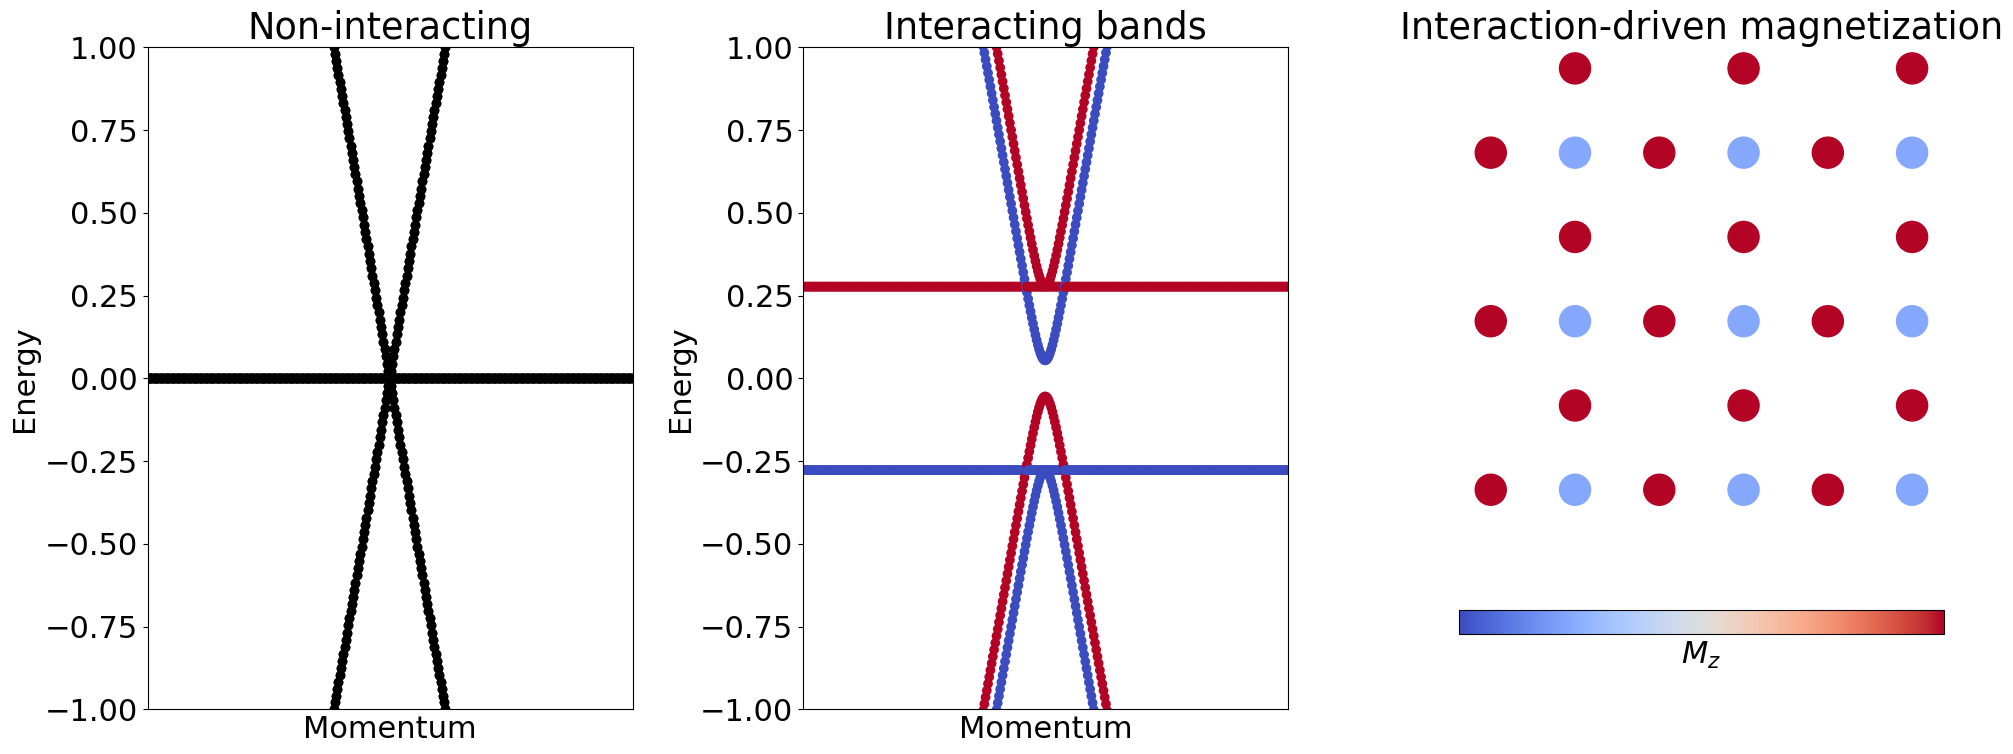

In [9]:
from pyqula import geometry
g = geometry.lieb_lattice() # generate a Lieb lattice

# first plot the non-interacting bands
plt.subplot(1,3,1) ; plt.title("Non-interacting")
h = g.get_hamiltonian() # generate the Hamiltonian
(k,e) = h.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-1.,1.])# plot
plt.xlim([min(k),max(k)])

# compute the mean-field Hamiltonian
U = 1.0 # value of the interaction
hscf = h.get_mean_field_hamiltonian(U=U,mix=0.9,mf="ferro") # perform mean-field

# plot the interacting bands
plt.subplot(1,3,2) ; plt.title("Interacting bands")
(k,e,c) = hscf.get_bands(operator="sz") # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-1.,1.])# plot
plt.xlim([min(k),max(k)])

# plot the selfconsistent magnetization
plt.subplot(1,3,3) ; plt.title("Interaction-driven magnetization")
NS = 3
hs = hscf.get_supercell(NS) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.scatter(gs.r[:,0],gs.r[:,1],c=mz,vmin=-.1,vmax=.1,s=500) ; plt.axis("off") ; plt.axis("equal")
plt.colorbar(label="$M_z$",ticks=[],orientation="horizontal")
plt.tight_layout() # adjust subplots

### Exercise
- Change the value of the interaction U. Do you have an instability also for smaller U?
- Discuss how this can be understood in terms of the Stoner instability
- Take a different supercell N, and discuss if you observe flat bands and interaction-induced magnetization
- Replace the honeycomb lattice by a square lattice with even N. Show that flat bands and a magnetization appears in the unit cell

## (Exercise) Non-collinear magnetism from competing interactions
Let us now include further neighbor hoppings, which promotes competing magnetic interactions

(np.float64(-10.45),
 np.float64(10.45),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

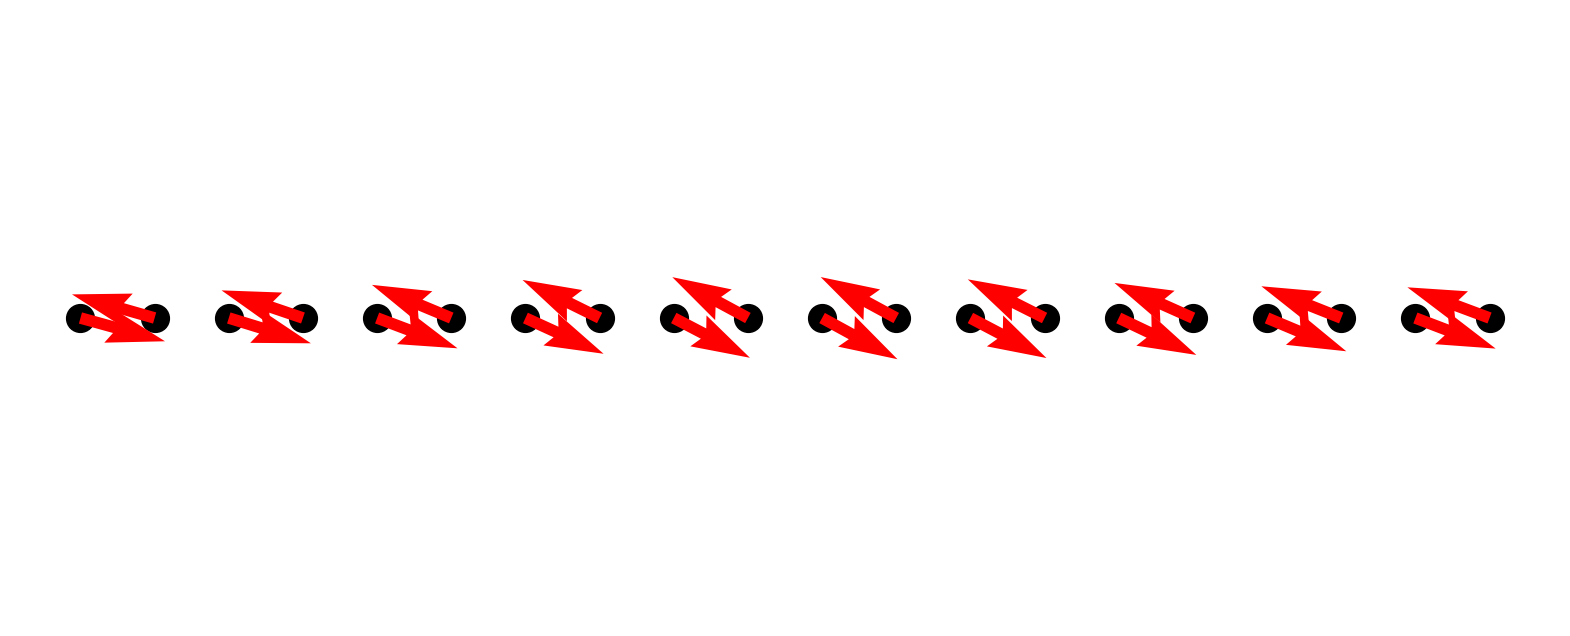

In [10]:
from pyqula import geometry
g = geometry.chain() # generate a chain 
g = g.get_supercell(20) ; g.dimensionality = 0 # use open boundaries, to avoid incommensurability issues
h = g.get_hamiltonian(tij=[1.,.3]) # generate the Hamiltonian

# generate the selfconsistent (SCF) Hamiltonian
U = 10. # strong Hubbard interaction
h = h.get_mean_field_hamiltonian(U=U,mf="XY",mix=0.9) # solve the interacting problem with a mean-field guess
mx = h.extract("mx") ; my = h.extract("my") ; x = h.geometry.r[:,0] ; y = h.geometry.r[:,1] # get magnetization
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,mx,my,color="red") ; plt.axis("off") # plot magnetization

### Exercise
- Discuss why including second neighbor hopping gives rise to a non-collinear magnetic state
- Is there a long neighbor hopping that can be included that does not lead to non-collinearity? Include it and show that you recover the antiferromagnetic state

#### In the lab
- Non-collinear magnetism coming from copeting interactions is observed in 2D materials, and in particular in the multiferroic monolayer NiI2
https://www.nature.com/articles/s41586-021-04337-x

## (Exercise) Non-collinear magnetism from spin-orbit coupling
We will now see that spin-orbit coupling is also able to generate a non-collinear magnetic texture

(np.float64(-4.95),
 np.float64(4.95),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

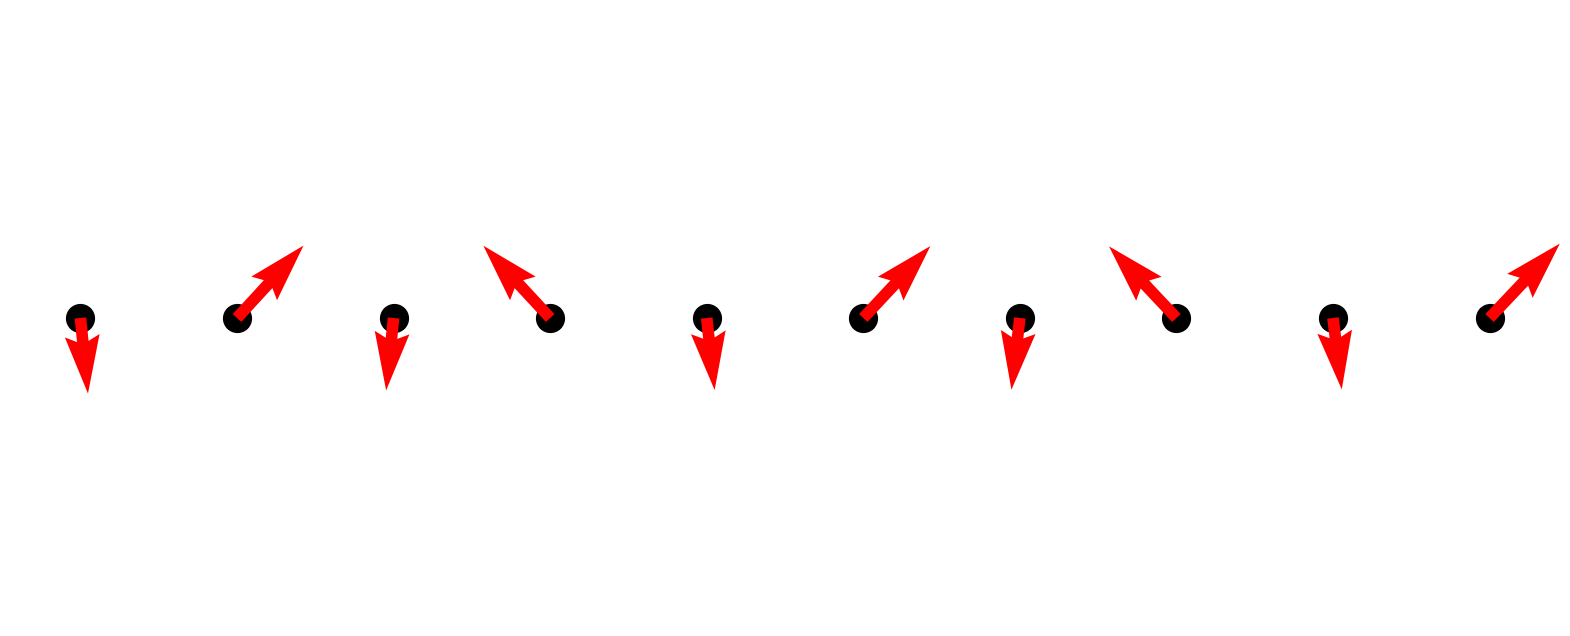

In [11]:
from pyqula import geometry
g = geometry.chain() # generate a chain 
g = g.get_supercell(10) ; g.dimensionality = 0 # use open boundaries, to avoid incommensurability issues
h = g.get_hamiltonian() # generate the Hamiltonian
h.add_rashba(1.) # add Rashba spin-orbit coupling

# generate the SCF Hamiltonian
U = 10. # strong Hubbard interaction
h = h.get_mean_field_hamiltonian(U=U,mf="XY",mix=0.9) # solve the interacting problem with a mean-field guess
mx = h.extract("mx") ; my = h.extract("my") ; x = h.geometry.r[:,0] ; y = h.geometry.r[:,1] # get magnetization
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,mx,my,color="red") ; plt.axis("off") # plot magnetization

### Quiz
- Discuss why spin-orbit coupling gives rise to non-collinear magnetism
- What is the term in the spin Hamiltonian that Rashba SOC generates?
- What happens to the spin texture if the sign of the Rashba term is reversed? (Physically, it means flipping the sample upside down)

## (Exercise) Magnetic instabilities of the square lattice
Let us now address the magnetic instabilities of the square lattice

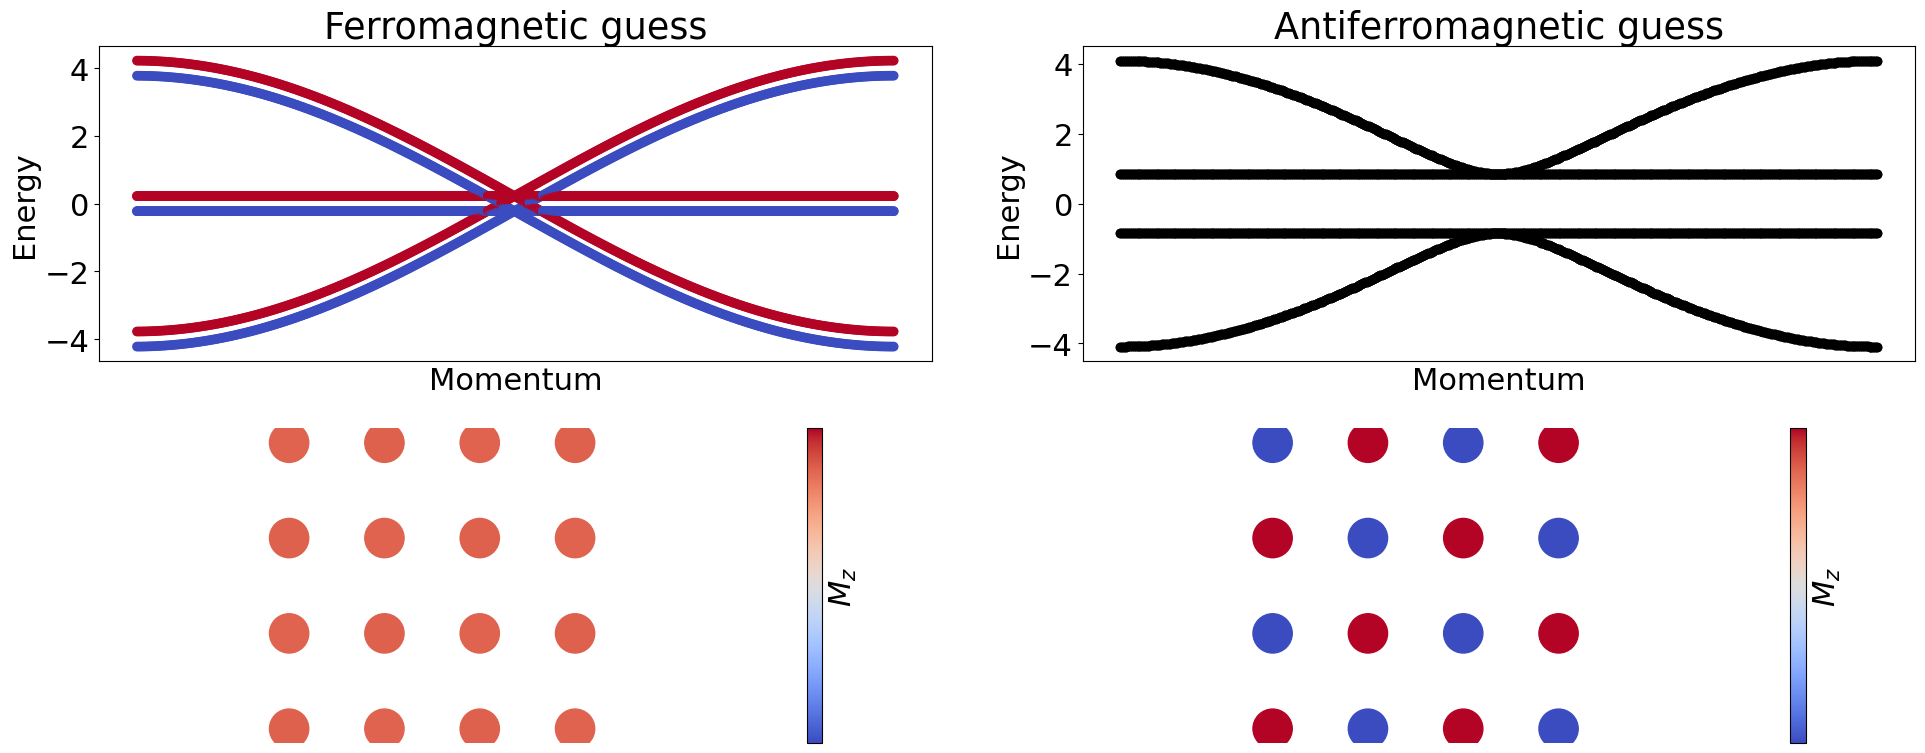

In [12]:
from pyqula import geometry
g = geometry.square_lattice_bipartite() # generate a chain with two sites per unit cell
h = g.get_hamiltonian() # generate the Hamiltonian

# let us now add interactions, and compute the electronic structure
U = 3.0 # value of the local interaction

# first with a ferromagnetic guess
plt.subplot(2,2,1)
plt.title("Ferromagnetic guess")

hfe = h.get_mean_field_hamiltonian(U=U,mf="ferro",mix=0.9) # FE guess
(k,e,c) = hfe.get_bands(operator="sz") # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

# plot z-component of the magnetization
hs = hfe.get_supercell(2) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,3)
plt.scatter(gs.r[:,0],gs.r[:,1],c=mz,vmin=-.3,vmax=.3,s=800) ; plt.yticks([]) ; plt.xticks([])
plt.axis("equal") ; plt.axis("off")
plt.colorbar(label="$M_z$",ticks=[])

# and with an antiferromagnetic guess
plt.subplot(2,2,2)
plt.title("Antiferromagnetic guess")
haf = h.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9) # AF guess
(k,e) = haf.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

# plot z-component of the magnetization
hs = haf.get_supercell(2) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,4)
plt.scatter(gs.r[:,0],gs.r[:,1],c=mz,vmin=-.3,vmax=.3,s=800) ; plt.yticks([]) ; plt.xticks([]) 
plt.axis("equal") ; plt.axis("off")
plt.colorbar(label="$M_z$",ticks=[])

plt.tight_layout()

## (Exercise) Non-collinear magnetic order from geometric frustration
We will now address 2D models that show non-collinear magnetism due to the geometric frustration of the lattice.

(np.float64(-4.124999999999999),
 np.float64(4.124999999999999),
 np.float64(-2.3815698604072066),
 np.float64(2.381569860407206))

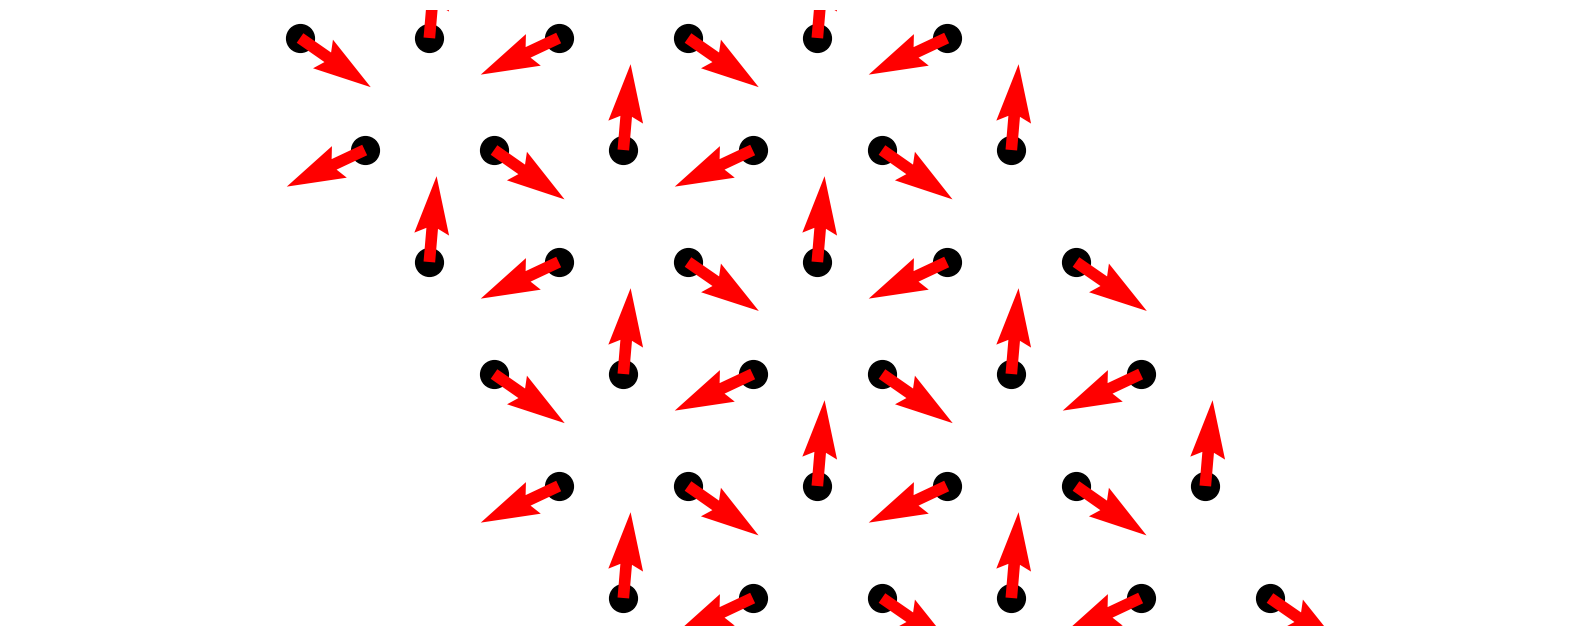

In [13]:
from pyqula import geometry
g = geometry.triangular_lattice() # generate a chain 
g = g.get_supercell((3,3)) # make a supercell
h = g.get_hamiltonian() # generate the Hamiltonian

# generate the SCF Hamiltonian
U = 10. # strong Hubbard interaction
h = h.get_mean_field_hamiltonian(U=U,mf="XY",mix=0.9) # solve the interacting problem with a mean-field guess
hs = h.get_supercell(2) # generate a supercell
mx = hs.extract("mx") ; my = hs.extract("my") ; x = hs.geometry.r[:,0] ; y = hs.geometry.r[:,1] # get magnetization
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,mx,my,color="red")  # plot magnetization
plt.axis("equal") ; plt.axis("off")

### Quiz
- Plot the band structure for the SCF solution for the 3x3 supercell, and estimate its gap
- Plot the band structure for the SCF solution for the 1x1 supercell, and estimate its gap
- Can you infer which one is the lowest energy solution, and why?

### In the lab
- 1T-NbSe2 hosts a triangular lattice of magnetic sites, stemming from the charge density wave instability of the compound, each spin living in a charge density wave
https://www.science.org/doi/10.1126/sciadv.abi6339

## (Exercise) Electronic instabilities in graphene multilayers
Let us now address specific graphene multilayers, and show how magnetic instabilities can emerge due to their enhanced density of states

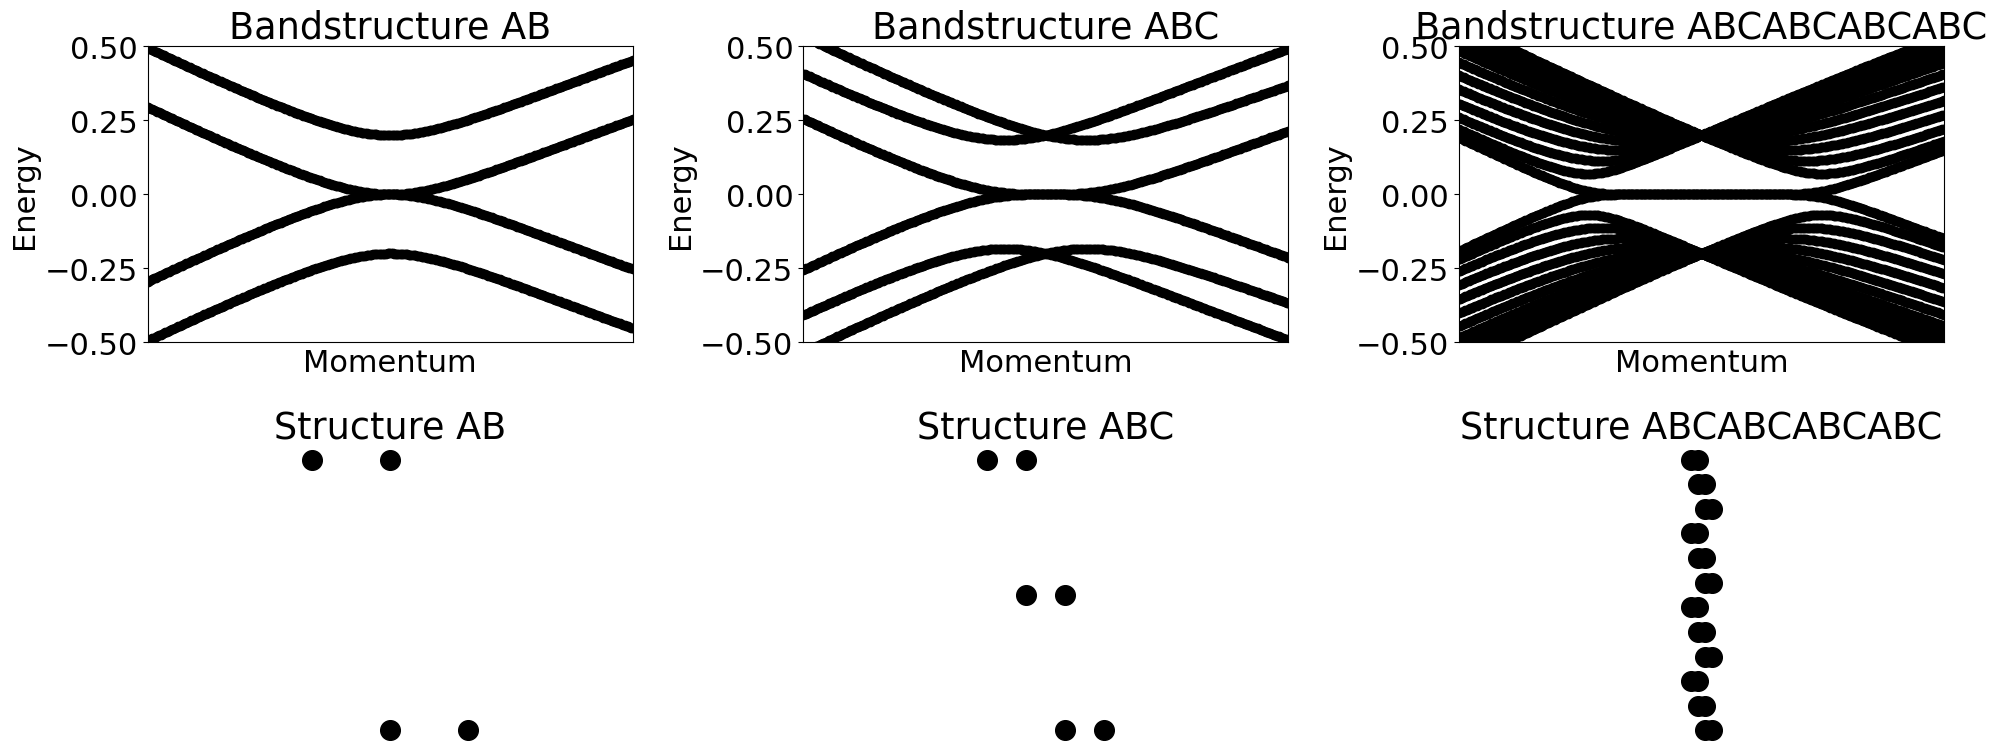

In [14]:
from pyqula import specialhamiltonian
mls = ["AB","ABC","ABCABCABCABC"] # graphene multilayers to consider
ii = 1 # counter
for m in mls: # loop over multilayers
    h = specialhamiltonian.multilayer_graphene(l=m,ti=0.2) # Hamiltonian of the graphene multilayer
    # make a small Kpath around the K point
    Kp = h.geometry.get_kpath(["K"])[0] ; kpath = [dk*Kp for dk in np.linspace(0.9,1.1,300)]
#    h = h.get_supercell(4) # make a supercell to see the bands easier
#    h.add_onsite(lambda r: r[2]*0.1/np.max(h.geometry.r[:,2])) # to add an electric field 
    (k,e) = h.get_bands(nk=300,kpath=kpath) # compute band structure
    plt.subplot(2,len(mls),ii) ; plt.title("Bandstructure "+m)
    plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) 
    plt.ylim([-.5,.5]) ; plt.xlim([min(k),max(k)])
    plt.subplot(2,len(mls),ii+len(mls)) ; plt.title("Structure "+m) ; gs = h.geometry
    plt.scatter(gs.r[:,0],gs.r[:,2],c="black",s=200) ; plt.axis("equal") ; plt.axis("off")
    ii += 1
    
plt.tight_layout() # tight layout

### Quiz
- Which of the three graphene multilayers above can have a stronger electronic instability? Discuss why
- Add an interlayer bias (as noted in the comment). What happens to the electronic structure?

## (Exercise) Magnetic symmetry breaking in graphene multilayers
We will now add interactions to a grpahene multilayer, and see that those interactions open up a gap

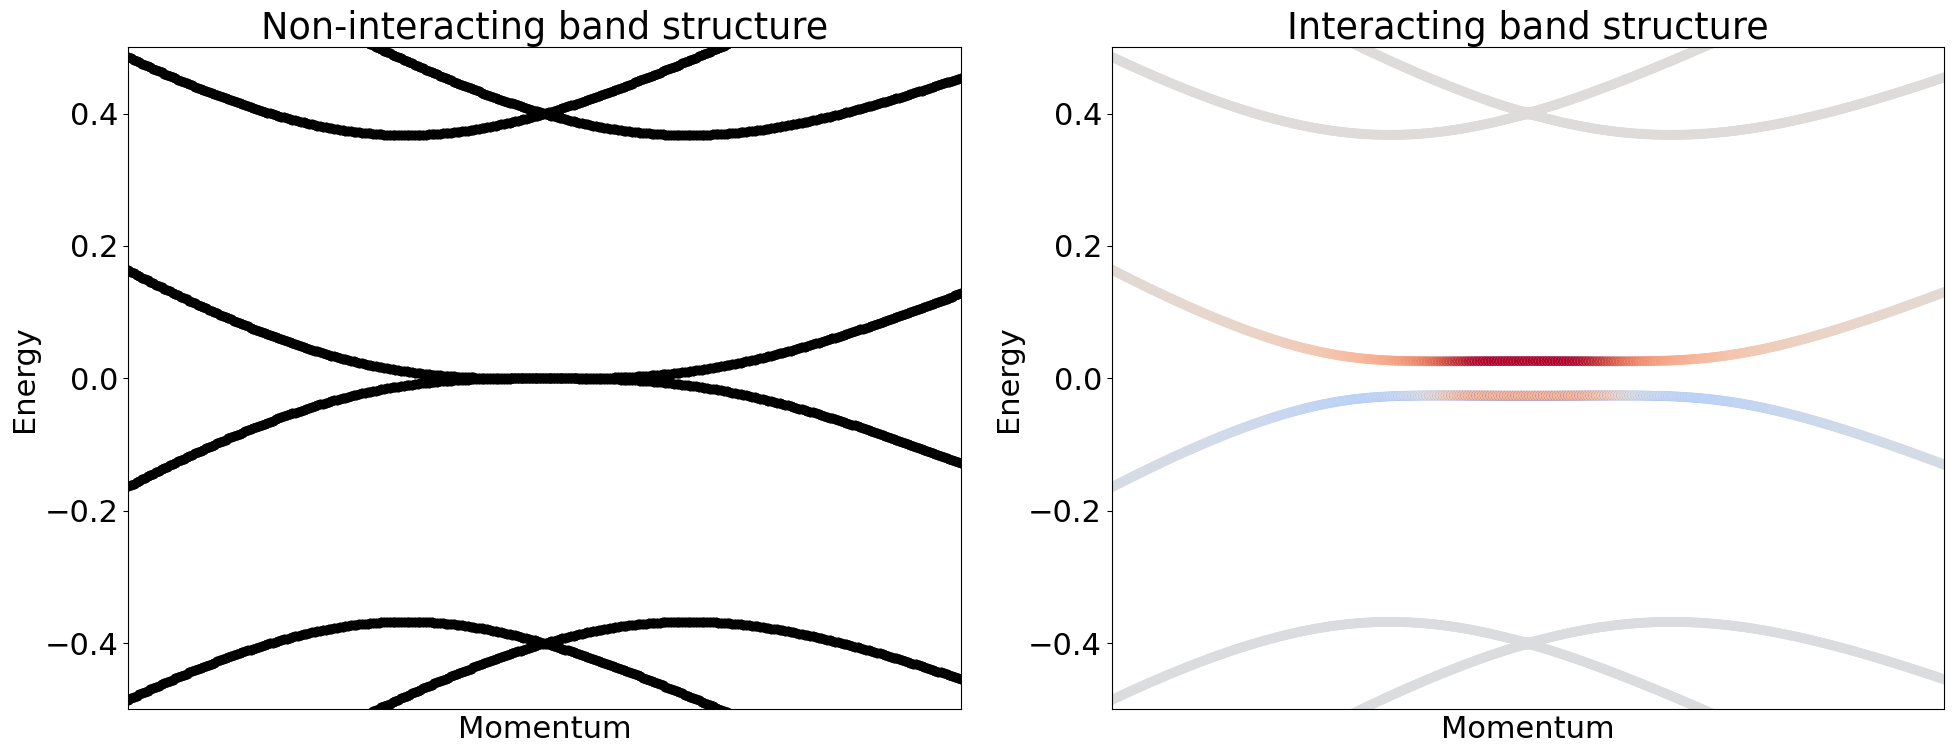

In [15]:
from pyqula import specialhamiltonian
h = specialhamiltonian.multilayer_graphene(l="ABC",ti=0.4) # Hamiltonian of the graphene multilayer
h.turn_spinful() 
# first plot the non-interacting bands
plt.subplot(1,2,1) ; plt.title("Non-interacting band structure")
# kpath around the K point
Kp = h.geometry.get_kpath(["K"])[0] ; kpath = [dk*Kp for dk in np.linspace(0.9,1.1,300)]
(k,e) = h.get_bands(nk=400,kpath=kpath) # compute band structure 
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
plt.xticks([]) ; plt.ylim([-.5,.5]) ; plt.xlim([min(k),max(k)])

# compute the mean-field Hamiltonian
U = 2. # value of the interaction
hscf = h.get_mean_field_hamiltonian(U=U,filling=0.5,mix=0.9,mf="random",nk=30) # perform SCF

# plot the interacting bands
plt.subplot(1,2,2) ; plt.title("Interacting band structure")
op = hscf.get_operator("sz")*hscf.get_operator("sublattice")
(k,e,c) = hscf.get_bands(operator=op,nk=400,kpath=kpath) # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
plt.xticks([]) ; plt.ylim([-.5,.5]) ; plt.xlim([min(k),max(k)])

plt.tight_layout() # adjust subplots

### Quiz
- Replace the multilayer by a single graphene monolayer. Do you still observe the electronic instability? Discuss why
- Add an out of plane electric field in the sample (add_onsite). What happens to the electronic instability?
- Change the doping of the system (filling), how does the electronic instability change?

#### In the lab
- Symmetry breaking in aligned multilayers has been observed experimentally for a variety of different thicknesses
https://www.science.org/doi/10.1126/science.aar6855

## (Exercise) Spinon Fermi surface in gapless quantum spin liquids
In the description of quantum spin liquids, effective single particle excitations known as spinons arise, that can be effectively described with a tight binding Hamiltonian. Here we will see how the Fermi surface of a gapless quantum spin liquid in the triangular lattice can evolve as a function of the couplings

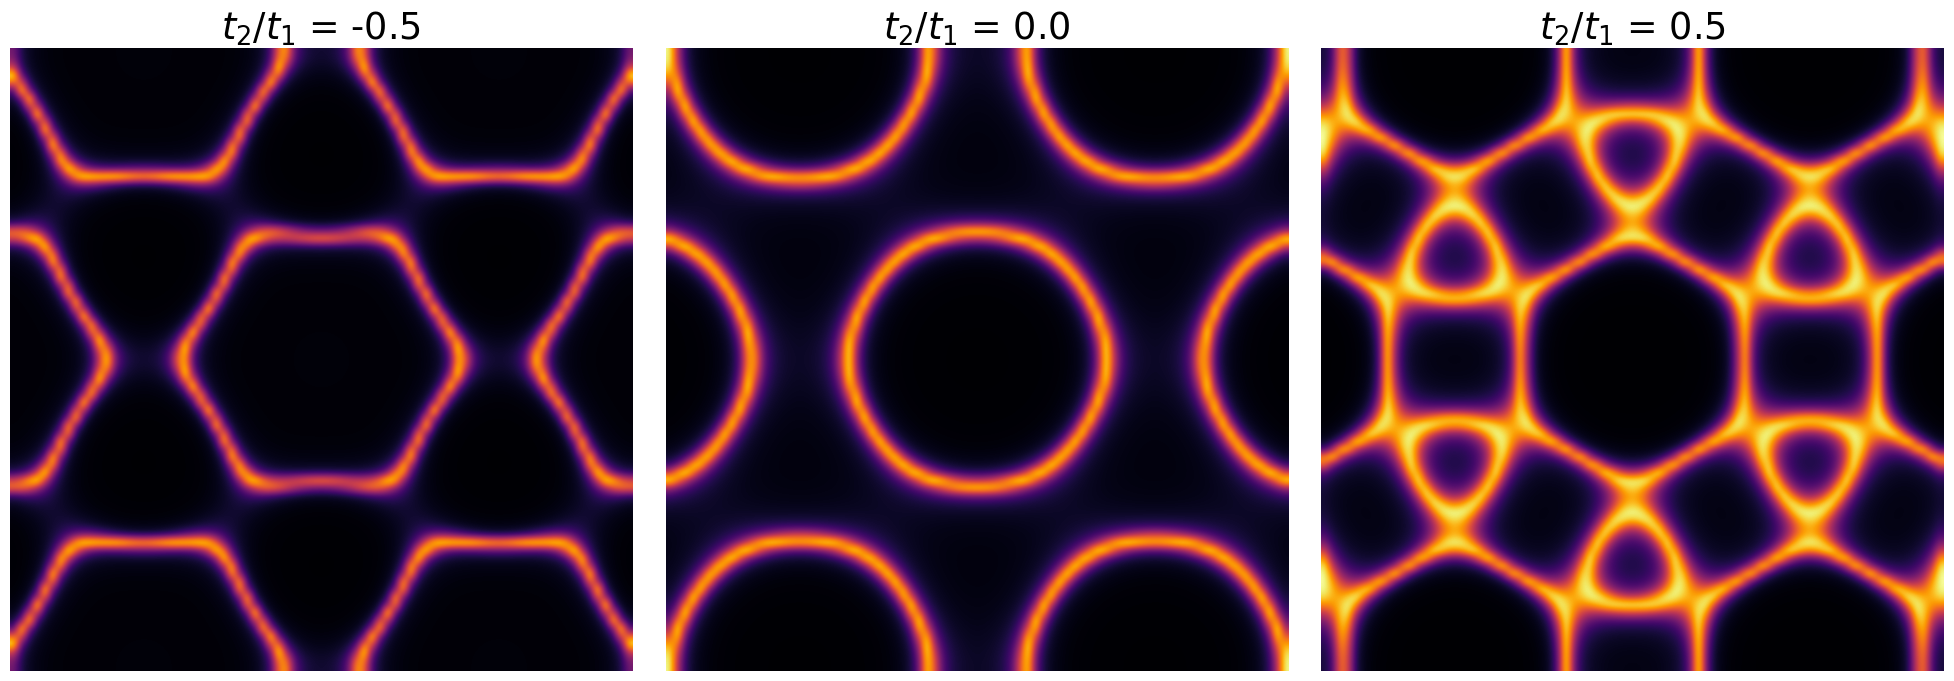

In [16]:
from pyqula import geometry
g = geometry.triangular_lattice() # generate a honeycomb lattice
nk = 80 ; delta = 30./nk # smearing and kmesh
t2s = np.linspace(-0.5,0.5,3) # loop over t2s
ip = 1 # counter for the plot
for t2 in t2s: # loop over t2s
    h = g.get_hamiltonian(tij=[1.,t2]) ; h.set_filling(0.5,nk=10) # generate the Hamiltonian at half filling
    (x,y,d) = h.get_fermi_surface(e=0.,delta=delta,nk=nk) # compute Fermi surface
    plt.subplot(1,len(t2s),ip) ; ip += 1 # set subplot
    d2d = d.reshape((nk,nk)) ; plt.imshow(d2d,vmin=0.,vmax=2./delta,cmap="inferno",interpolation="bicubic") 
    plt.title("$t_2/t_1$ = "+str(np.round(t2,2))) ; plt.axis("off")
plt.tight_layout()

### Quiz
- Replace the triangular lattice by a square lattice (square_lattice), recompute the spinon Fermi surfaces
- Replace the triangular lattice by a Kagome lattice (kagome_lattice), recompute the spinon Fermi surfaces
- Discuss why the effective tight binding model should be enforced to be at half filling
- Discuss how the hoppings of the quantum spin liquid depend on the exchange coupling of the parent Heisenberg model

#### In the lab
- Signatures of spinon Fermi surfaces in the triangular lattice have been observed with scanning tunnel microscopy
https://www.nature.com/articles/s41567-021-01321-0

## (Exercise) Topological magnons in 2D magnets
Ordered 2D magnets feature magnon excitations, that can be effectively described with a single particle Hamiltonian. Here we will see how such magnon excitations can develop a topological gap, leading to edge states

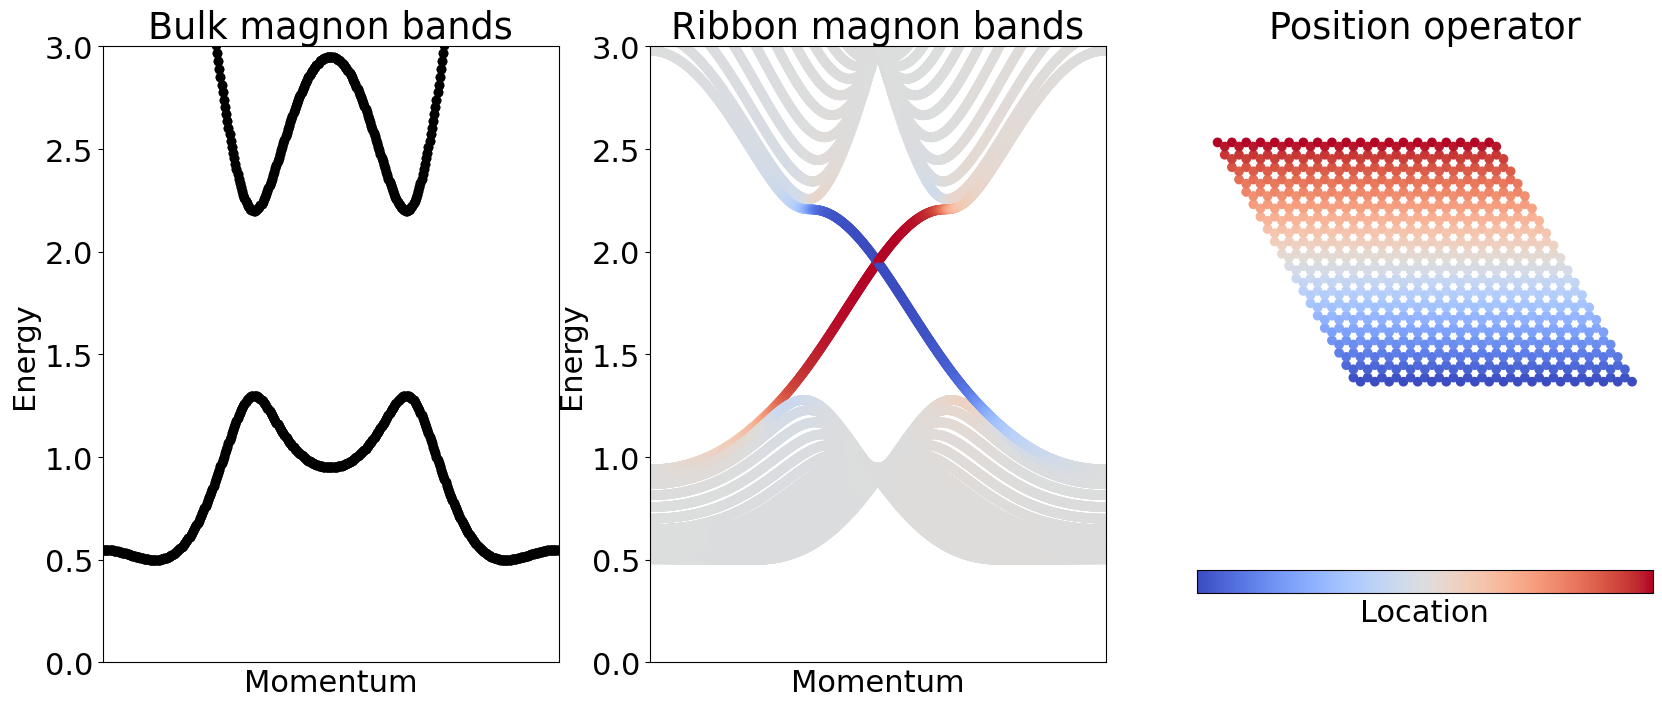

In [17]:
from pyqula import geometry, ribbon
g = geometry.honeycomb_lattice() # honeycomb lattice
h = g.get_hamiltonian(tij=[1.,0.2]) # generate the Hamiltonian
h.add_haldane(0.1) # add a coupling leadin to a topologicla gap
h.set_filling(0.0) ; h.add_onsite(0.5) # zero filling, and add a gap

# plot the bulk bands
plt.subplot(1,3,1) ; plt.title("Bulk magnon bands")
(k,e) = h.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
plt.xticks([]) ; plt.xlim([min(k),max(k)]) ; plt.ylim([0.,3.])# plot

h = ribbon.bulk2ribbon(h,n=20)

# plot the bands
plt.subplot(1,3,2) ; plt.title("Ribbon magnon bands")
(k,e,c) = h.get_bands(operator="yposition") # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
plt.xticks([]) ; plt.xlim([min(k),max(k)]) ; plt.ylim([0.,3.])# plot

# draw a ribbon with the position operator
gs = h.geometry.get_supercell(20) 
plt.subplot(1,3,3) ; plt.title("Position operator")
plt.scatter(gs.r[:,0],gs.r[:,1],c=gs.r[:,1]) ; plt.axis("equal") ; plt.axis("off")
plt.colorbar(label="Location",ticks=[],orientation="horizontal")

### Quiz
- Change the value of the coupling opening a topologicla magnon gap (add_haldane). Do you still observe magnon edge states?
- Change the value of the second neighbor hopping (tij=[1.,t2]). Do you still observe magnon edge states?
- Discuss why the magnon eigenspectra should be positive

#### In the lab
- Signatures of magnon gaps at the Dirac pont in CrI3 have been observed
https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.041028

## (Exercise) Quantum magnetism in the Kondo lattice
We now explore how the electronic structure of a van der Waals material is modified in the presence of a Kondo lattice. In the screened regime, a Kondo lattice will open up a heavy fermion gap in a metallic 2D material

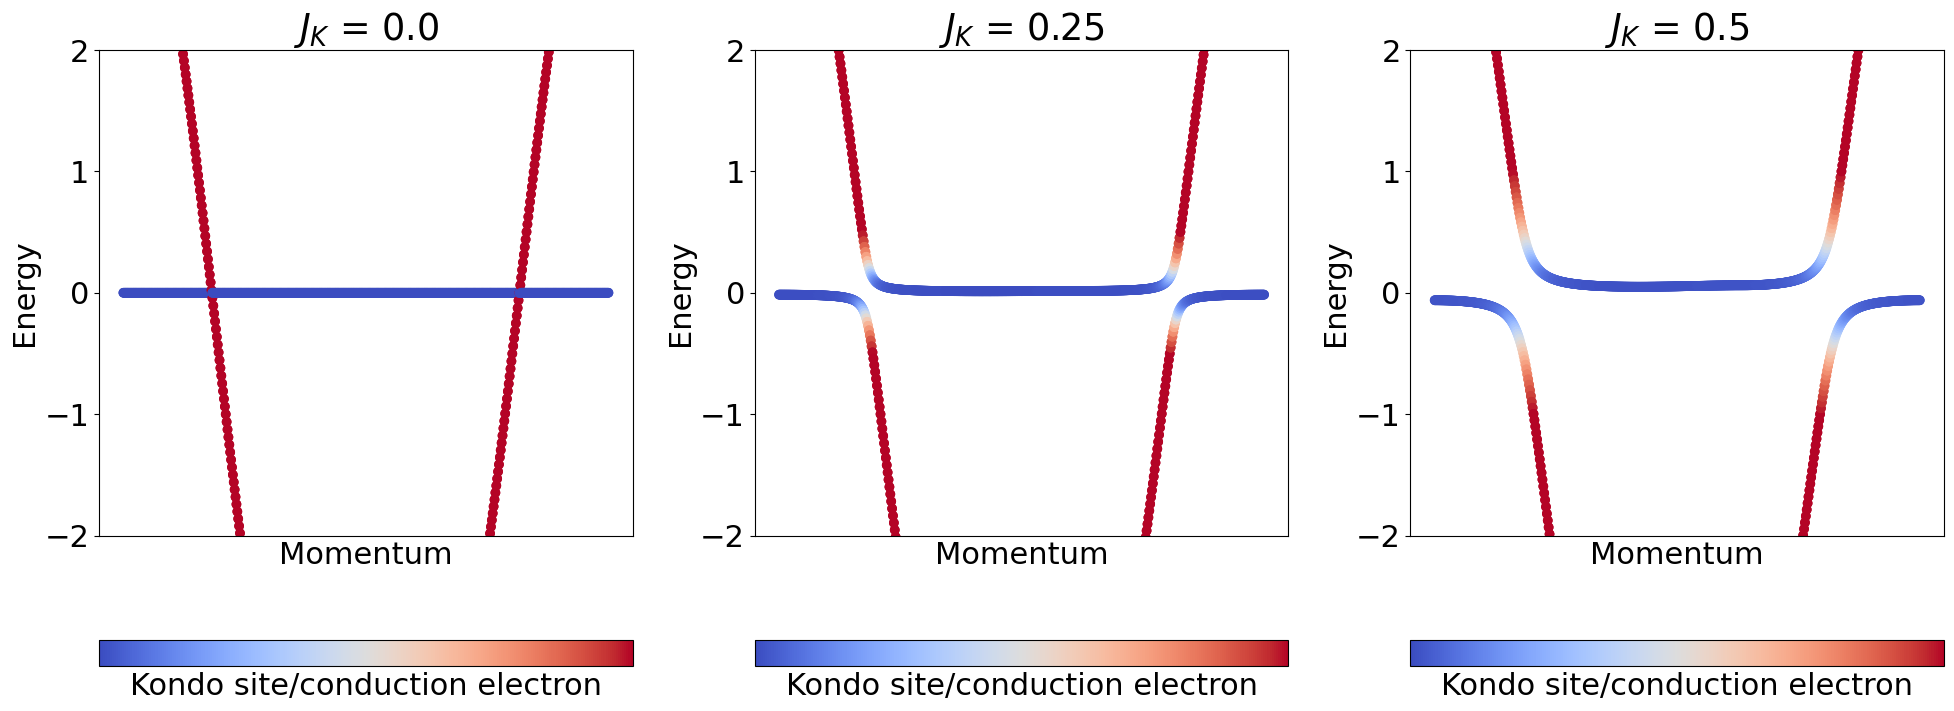

In [18]:
from pyqula import geometry
from pyqula.specialhamiltonian import H2HFH # promote a Hamiltonian to a heavy-fermion Hamiltonian
JKs = np.linspace(0.,.5,3) # chemical potentials
g = geometry.triangular_lattice() # take a square lattice
iw = 1 # counter
delta = 0.5 # value of the superconducting order
for JK in JKs: # loop over local potentials
    h = g.get_hamiltonian() ; h.add_onsite(-2.0) # generate Hamiltonian
    h = H2HFH(h,JK=JK) # add a Kondo lattice in the fully screened regime 
    plt.subplot(1,len(JKs),iw) 
    iw +=1 ; plt.title("$J_K$ = "+str(np.round(JK,3)))
    (k,e,c) = h.get_bands(operator="dispersive_electrons",kpath=["G","K","M","G"]) # compute band structure
    plt.scatter(k,e,c=c,vmin=0.,vmax=0.8) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
    plt.xticks([]) ; plt.ylim([-2.,2.])
    plt.colorbar(label="Kondo site/conduction electron",ticks=[],orientation="horizontal")
plt.tight_layout() # adjust

### Exercise
- Discuss what is the origin of the flat blue band
- Discuss what is the physical origin of the anticrossing between the blue and red band
- Change the chemical potential. Do you still observe a gap opening in the electronic structure? Discuss why

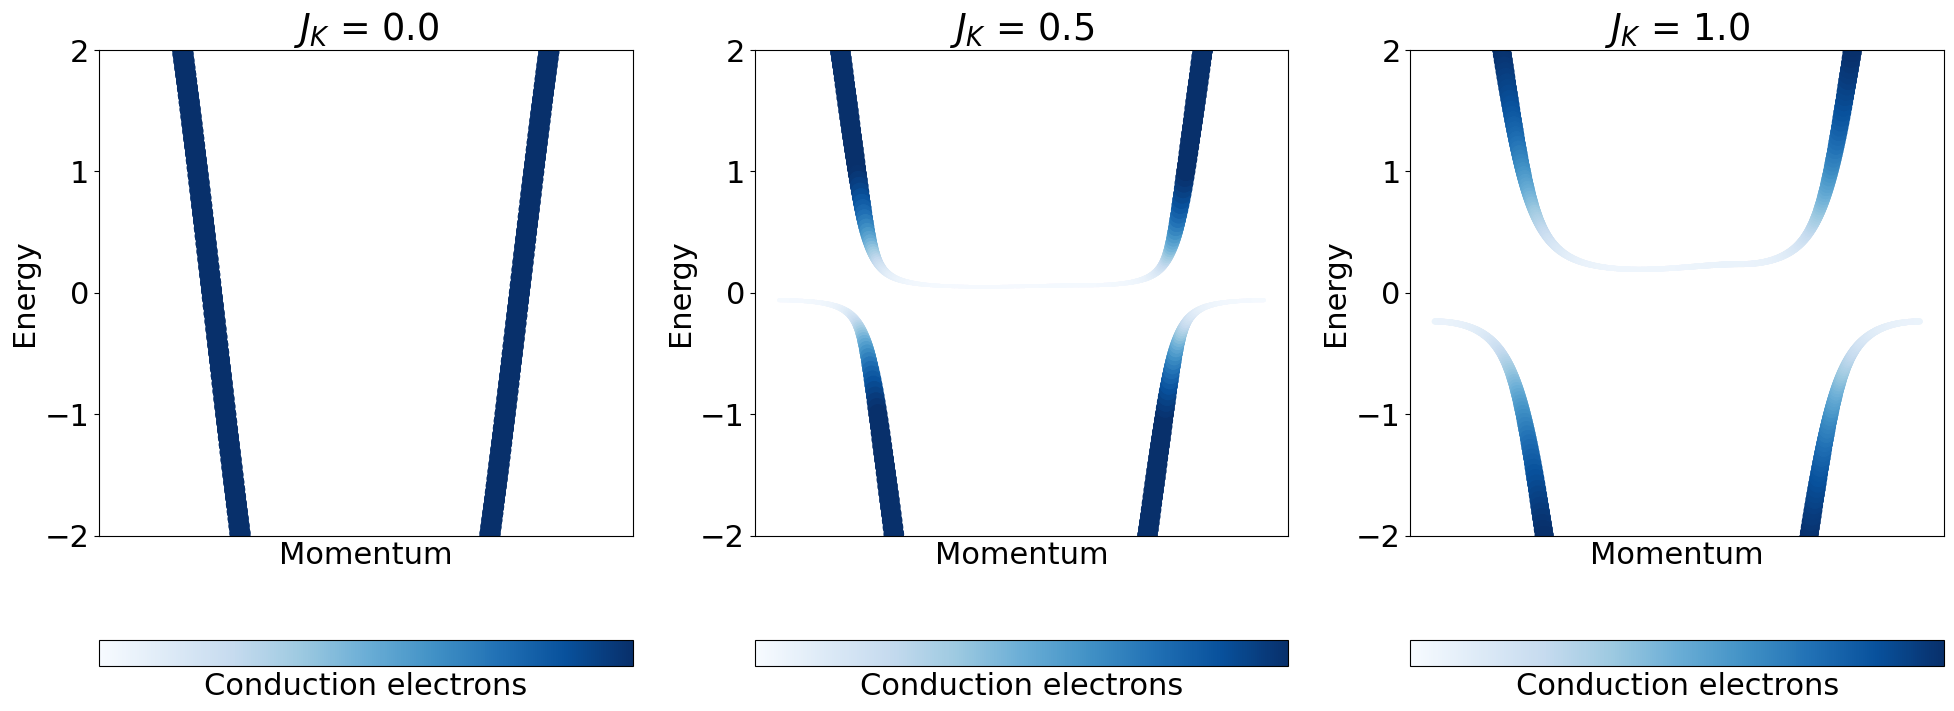

In [19]:
from pyqula import geometry
from pyqula.specialhamiltonian import H2HFH # promote a Hamiltonian to a heavy-fermion Hamiltonian
JKs = np.linspace(0.,1.,3) # chemical potentials
g = geometry.triangular_lattice() # take a triangular lattice
iw = 1 # counter
delta = 0.5 # value of the superconducting order
JK = 1. # Kondo coupling
for JK in JKs: # loop over local potentials
    h = g.get_hamiltonian() ; h.add_onsite(-2.0) # generate Hamiltonian
    h = H2HFH(h,JK=JK) # add a Kondo lattice in the fully screened regime 
    plt.subplot(1,len(JKs),iw) 
    iw +=1 ; plt.title("$J_K$ = "+str(np.round(JK,3)))
    (k,e,c) = h.get_bands(operator="dispersive_electrons",kpath=["G","K","M","G"]) # compute band structure
    plt.scatter(k,e,c=c,s=200*c,cmap="Blues",vmin=0.,vmax=0.8) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") 
    plt.xticks([]) ; plt.ylim([-2.,2.])
    plt.colorbar(label="Conduction electrons",ticks=[],orientation="horizontal")
plt.tight_layout() # adjust

### Quiz
- Change the chemical potential. Do you still observe a gap opening in the electronic structure? Discuss why
- Replace the triangular lattice by a honeycomb lattice. Do you observe a gap opening? Discuss why

#### In the lab
- Heavy fermions in a van der Waals heterostructure leading to a Kondo insulator have been observed in 1T-TaS2/1H-TaS2 heterostructures
https://www.nature.com/articles/s41586-021-04021-0